In [1]:
!pip install tavily-python


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
OPENAI_API_KEY="voc-*"

In [3]:
TAVILY_API_KEY="tav-*"

In [ ]:
import os
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv

In [5]:
load_dotenv()

False

In [6]:
@tool
def random_got_quote_tool()->Dict:
    """
    Return a random Game of Thrones quote and the character who said it
    """
    response = requests.get("https://api.gameofthronesquotes.xyz/v1/random")
    return response.json()

In [7]:
random_got_quote_tool.invoke({})

{'sentence': "You're not a golden lion. You're just a pink little man, who is far too slow on the draw. ",
 'character': {'name': 'Oberyn Martell',
  'slug': 'oberyn',
  'house': {'name': 'House Martell of Sunspear', 'slug': 'martell'}}}

In [8]:
tavily_client = TavilyClient(
#     api_key=os.getenv("TAVILY_API_KEY"),
    api_key=TAVILY_API_KEY,
)

In [ ]:
# !echo $TAVILY_API_KEY

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


In [10]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    response = tavily_client.search(question)
    return response

In [11]:
web_search.invoke(
    {
        "question": "Who performs Cersei Lannister in Game of Thrones?"
    }
)

{'query': 'Who performs Cersei Lannister in Game of Thrones?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.instagram.com/iamlenaheadey/?hl=en',
   'title': 'Lena Headey (@iamlenaheadey)',
   'content': '... playing Cersei Lannister in "Game of Thrones". \'The Exiled\' shows Gaza ... lena headey and gillian anderson playing powerful matriarchs of two warring families?!?',
   'score': 0.99783427,
   'raw_content': None},
  {'url': 'https://www.facebook.com/groups/454901272364493/posts/1167819824405964/',
   'title': "Lena Headey's portrayal of Cersei Lannister in Game ...",
   'content': "Currently doing a rewatch and I gotta say Lena Headey's performance as Cersei Lannister is my favorite and honestly the most unforgettable from",
   'score': 0.99690056,
   'raw_content': None},
  {'url': 'https://time.com/4773785/lena-headey-cersei-game-of-thrones/',
   'title': 'Lena Headey on Playing Cersei on Game of Thrones',
   'content': 'So say

In [12]:
tools = [random_got_quote_tool, web_search]

In [13]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY,
)

In [14]:
llm_with_tools = llm.bind_tools(tools)

In [15]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [16]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent",
    path=router,
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


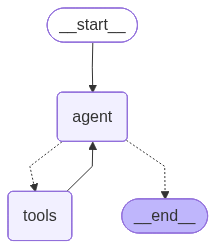

In [18]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
messages = [
    SystemMessage(
        "You are a Web Researcher focused on Game of Thrones. "
        "If user asks you a random quote about GoT. You will not only "
        "provide it, but also search the web to find the actor or actress "
        "who perform the character who said that."
        "So, your output should be: Quote, Character and Performer."
    ),
    HumanMessage("Give me a radom GoT quote")
]

In [20]:
result = graph.invoke(
    input={
        "messages": messages
    }
)

print(result)

{'messages': [SystemMessage(content='You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.', additional_kwargs={}, response_metadata={}, id='8b14446a-cf68-4417-ae43-d4cc9fa16da6'), HumanMessage(content='Give me a radom GoT quote', additional_kwargs={}, response_metadata={}, id='be02023a-78b9-48b7-bc1f-cb052db79193'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rKgYOvdUpD2L6s8dsgWDn0FF', 'function': {'arguments': '{}', 'name': 'random_got_quote_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 141, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

In [21]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.
================================ Human Message =================================

Give me a radom GoT quote
================================== Ai Message ==================================
Tool Calls:
  random_got_quote_tool (call_rKgYOvdUpD2L6s8dsgWDn0FF)
 Call ID: call_rKgYOvdUpD2L6s8dsgWDn0FF
  Args:
================================= Tool Message =================================
Name: random_got_quote_tool

{"sentence": "Everyone who makes a joke about a dwarf's height thinks he's the only person ever to make a joke about a dwarf's height.", "character": {"name": "Tyrion Lannister", "slug": "tyrion", "house": {"name": "House Lan